IMPORTING USEFUL LIBS

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

LOADING THE DATA

In [3]:
#reading from train , test and sample dataset
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
# Define feature columns and categorical columns
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

PRE-PROCESSING THE DATA

In [4]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


In [5]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


CREATING MAPPINGS AND THRESHOLDS

In [6]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


DEFINING THE TRAINING MODEL

In [7]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    thresholds = KappaOPtimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, thresholds)

    return tp_rounded

VISUALIZING THE DATA

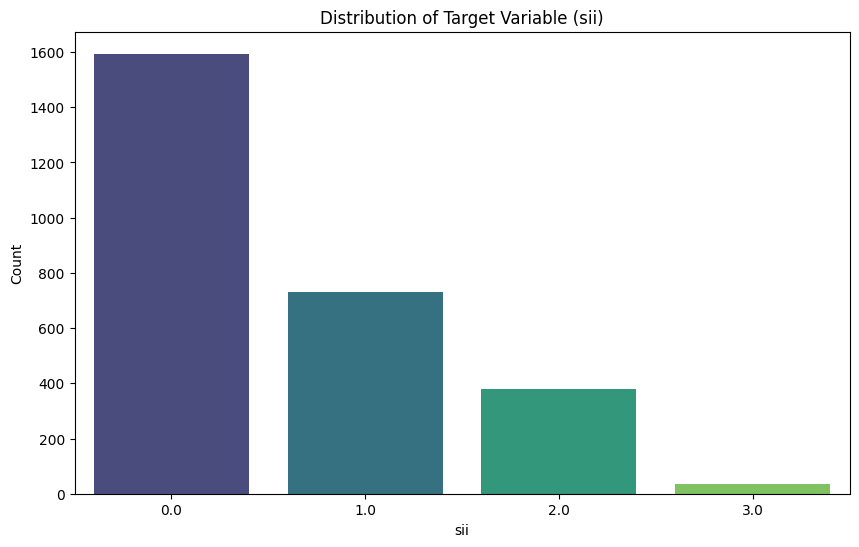

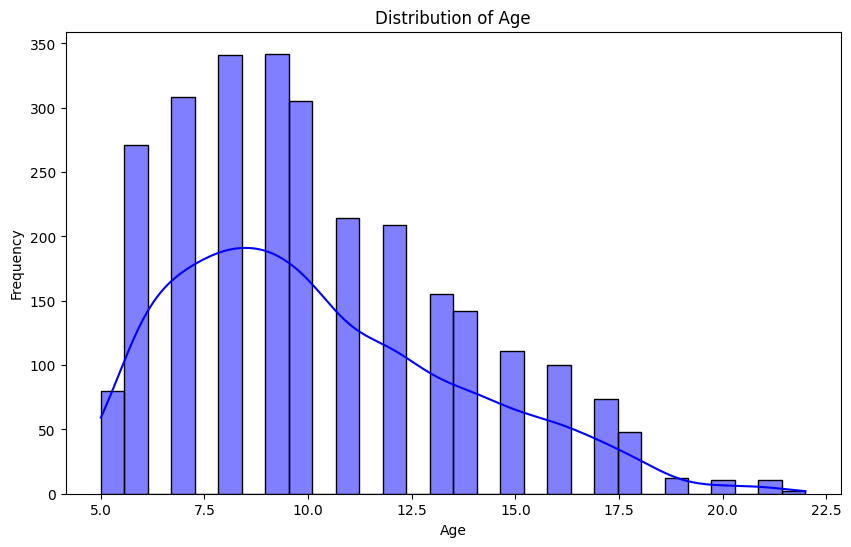

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of the target variable sii
plt.figure(figsize=(10, 6))
sns.countplot(x='sii', data=train, palette='viridis')
plt.title("Distribution of Target Variable (sii)")
plt.xlabel("sii")
plt.ylabel("Count")
plt.show()

# Visualize the distribution of a numerical feature, e.g., 'Basic_Demos-Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Basic_Demos-Age'].dropna(), kde=True, color='blue', bins=30)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

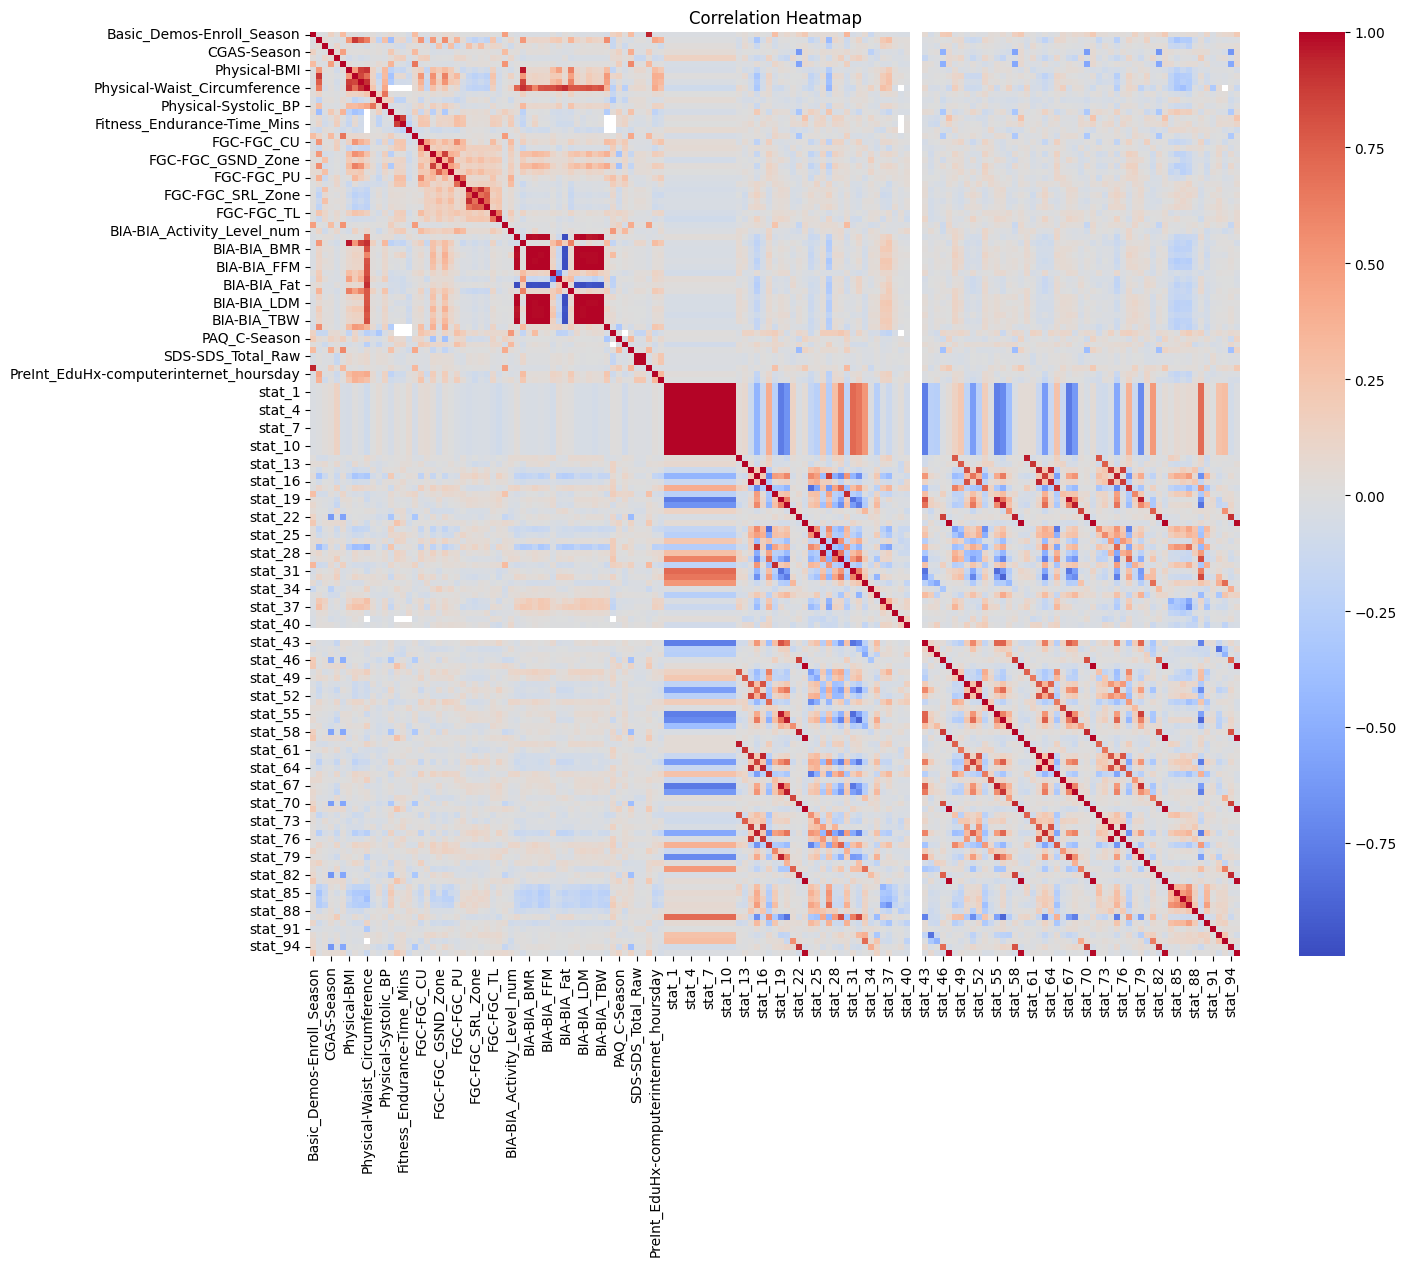

In [9]:
# Correlation matrix
numerical_cols = train.select_dtypes(include=['float64', 'int']).columns
correlation_matrix = train[numerical_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()
# Example: Visualizing a time-series feature
time_series_example = train_ts.iloc[0, 1:].values  # Taking the first time series for visualization


USING DIFFERENT MODELS

In [10]:
imputer = SimpleImputer(strategy='median')
SEED = 42
n_splits = 5

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

finalmodel = TrainML(ensemble, test)
finalmodel = pd.DataFrame({
    'id': sample['id'],
    'sii': finalmodel
})

finalmodel

Training Folds: 100%|██████████| 5/5 [02:30<00:00, 30.09s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


----> || Optimized QWK SCORE ::  0.450


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


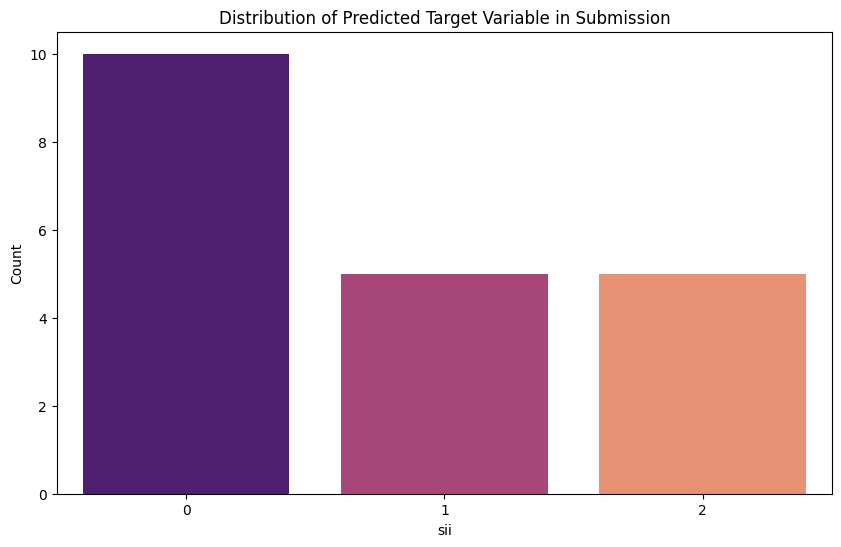

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sii', data= finalmodel, palette='magma')
plt.title("Distribution of Predicted Target Variable in Submission")
plt.xlabel("sii")
plt.ylabel("Count")
plt.show()